In [ ]:
# First attach your google drive to the colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/')
!ls


'baseline postprocessed preds'		       mrcnn
'baseline preds'			      'second experiment preds'
 classes.csv				       share_train_df.csv
 CryoNuSeg				       stage1_test
 external				       stage1_test.zip
 extra_data				       stage1_train
 kaggle-dsbowl-2018-dataset-fixes-master.zip   stage1_train_fixed
'Kaggle Mask-RCNN baseline.ipynb'	       stage1_train_original
 logs					       stage1_train.zip
'Mask-RCNN baseline.ipynb'		       stage2_decode.ipynb
'Mask-RCNN baseline modification.ipynb'        stage2_solution_final.csv
 mask_rcnn_coco.h5			       stage2_test
'Mask-RCNN for CryoNuSeg segmentation.ipynb'   stage2_test_final.zip
'Mask-RCNN for nuclei segmentation.ipynb'     'TF2 Project'
 MoNuSeg2018TrainingData.zip


In [ ]:
!mkdir stage2_test

In [ ]:
!unzip stage2_test_final.zip -d stage2_test/

Output streaming troncato alle ultime 5000 righe.
   creating: stage2_test/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8/images/
  inflating: stage2_test/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8/images/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8.png  
   creating: stage2_test/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231/images/
  inflating: stage2_test/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231/images/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231.png  
   creating: stage2_test/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17/images/
  inflating: stage2_test/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17/images/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17.png  
   creating: stage2_test/19699898bd07e3d27804bc52fea46d67a8d4c63ec75b5693910482855285fa90/images/
  inflating: stage2_test/19699898bd07e3d27804bc52fea46

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from skimage.io import imread

from matplotlib.patches import Polygon
from skimage.measure import find_contours
import os
import inspect
import random
from PIL import Image

test_id_list = sorted([test_id for test_id in os.listdir(stage1_test_dir) if not test_id.startswith('.')])


def get_test_image_by_id(img_id):
    img_path = os.path.join(stage1_test_dir, img_id, 'images', '%s.png' % img_id)
    return imread(img_path)[:, :, :3]


def get_random_color(pastel_factor=0.5):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0, 1.0) for i in [1, 2, 3]]]


def color_distance(c1, c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1, c2)])


def generate_new_color(existing_colors, pastel_factor=0.5):
    max_distance = None
    best_color = None
    for i in range(0, 100):
        color = get_random_color(pastel_factor=pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color, c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color


def rle_decode(rle_list, mask_shape, mask_dtype):

    # mask = np.zeros(mask_shape, dtype=mask_dtype)
    mask = np.zeros(np.prod(mask_shape), dtype=mask_dtype)
    for j, rle in enumerate(rle_list):
        s = rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[lo:hi] = (j+1)

    return mask.reshape(mask_shape[::-1]).T


def get_polygon(mask, color_list=list()):
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    color = generate_new_color(color_list, pastel_factor=0.5)
    color_list.append(color)
    p_list = []
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p = Polygon(verts, facecolor="none", edgecolor=color)
        p_list.append(p)

    return p_list


def plot_mask_2d(img, mask_2d, bbox_list=None, class_probs=None, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    ax.imshow(img)

    if title:
        ax.set_title(title)

    color_list = list()
    for j in range(1, np.max(mask_2d)+1):
        mask_j = mask_2d == j
        poly_list = get_polygon(mask=mask_j, color_list=color_list)
        for poly in poly_list:
            ax.add_patch(poly)

    if bbox_list is not None:
        for i_box in range(bbox_list.shape[0]):
            rect = patches.Rectangle((bbox_list[i_box][0], bbox_list[i_box][1]),
                                     bbox_list[i_box][2] - bbox_list[i_box][0],
                                     bbox_list[i_box][3] - bbox_list[i_box][1],
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            if class_probs is not None:
                ann_string = str(round(class_probs[i_box], 2))
                ax.annotate(ann_string, (bbox_list[i_box][0], bbox_list[i_box][1]), color='w',
                               weight='bold', fontsize=8, ha='left', va='bottom')


def get_test_mask(img_id):
    img_path = stage1_test_dir + '/' + img_id
    mask_files = next(os.walk(img_path + '/masks/'))[2]
    mask_files = sorted(mask_files)
    num_masks = len(mask_files)
    mask = imread(img_path + '/masks/' + mask_files[0])
    mask_2d = np.zeros(shape=[mask.shape[0], mask.shape[1]], dtype=np.int)

    for i_mask, mask_file in enumerate(mask_files):

        current_mask = imread(img_path + '/masks/' + mask_file)

        current_mask = (current_mask > 0).astype(int)

        assert np.sum(mask_2d[current_mask > 0]) == 0, 'Overlapping mask found!'

        mask_2d[current_mask > 0] = (i_mask + 1)

    return mask_2d


def sanity_check(max_n_images = 5):

    for i, test_id in enumerate(test_id_list):
        if i > max_n_images:
            break
        img = get_test_image_by_id(test_id)
        mask_2d = get_test_mask(img_id=test_id)
        plot_mask_2d(img=img, mask_2d=mask_2d)
        plt.show()


def decode_submission(filename, visualize=False):
    # filename = get_submission_path(run_name)

    df = pd.read_csv(filename, sep=',')

    df_ignore = df[df['Usage'] == "Ignored"]

    for i, test_id in enumerate(test_id_list):

        if((df_ignore['ImageId'] == test_id).any()):
            continue

        print('Test ID = ', test_id, i)

        img = get_test_image_by_id(test_id)
        rows, cols = img.shape[0], img.shape[1]

        mask_rles = df.loc[df['ImageId'] == test_id]
        mask = rle_decode(rle_list=mask_rles['EncodedPixels'], mask_shape=(rows, cols), mask_dtype=np.int)

        if visualize:
            plot_mask_2d(img=img, mask_2d=mask)
            plt.show()

        num_masks = np.max(mask)

        mask_dir = stage1_test_dir + '/' + test_id + '/masks/'

        os.makedirs(mask_dir, exist_ok=True)

        for i_mask in range(num_masks):

            c_mask = 255 * (mask == (i_mask + 1))

            mask_img_string = test_id + '_' + str(i_mask) + '.png'

            im = Image.fromarray(np.asarray(c_mask, dtype=np.uint8))
            im.save(mask_dir + mask_img_string)



Test ID =  024975b4dc2a415288664ea7fdf5d9582f8d19d0f8b4953d87444dfabfc11e19 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Test ID =  042ef58ce8420704ac352c7cf0f9d3fbc7d58899ce29879ffb46a21f9b321f5f 40
Test ID =  0514cc7f8da5ed8572eca6b9beab69a8ebe99a297d2cba24f1d743e910a4891f 55
Test ID =  0682759f81d3e26c9cebc9973f297025bbdb07b419edf748d98bab84594bc2f1 70
Test ID =  106423fb28a54151657c5f6f355c86c8f205bad6f5ff8a93a0c790bc1e711c2e 187
Test ID =  11b491bff441ad94b2df76cb030acf4aa0c4a6fcb6432d9612cd6f49fc041252 200
Test ID =  11ef794d62ef47d62bc712171353e5223c5e8ff0308e76590a2523f855180441 205
Test ID =  14e407f8c5c2f9f0e9ebf27f043b505e7e835434e7a3a0912df5bd6c267ce9a1 246
Test ID =  1993f30556b35c2ac453e5feaf715156463e948ad72fdf184e00a9b1968fe1b0 309
Test ID =  24928d37f8e4704fed57eb9521248f6e6680f581d487f8aae44491d8ac52d01f 446
Test ID =  28f81a16b6cd3459ff976bb01df6769fe887f9053197210128285d518a677c9e 508
Test ID =  2ad096cf3239478755b5397330cc68805e9860f54d210fb70107f67bd68a6ea7 526
Test ID =  2b3859805dfb2f15560ea9cc341b5a6df7fc1df5552092cec9b7cb40cd167a4c 534
Test ID =  2ed84f63ef4cda2912991335444836be

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


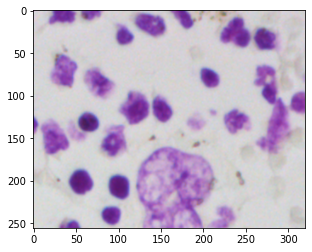

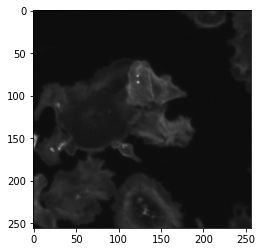

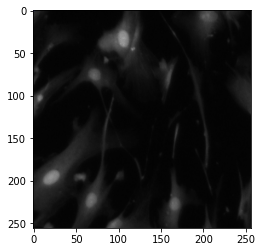

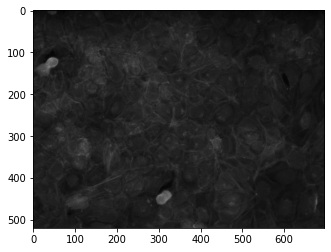

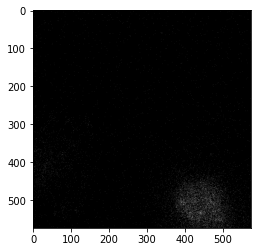

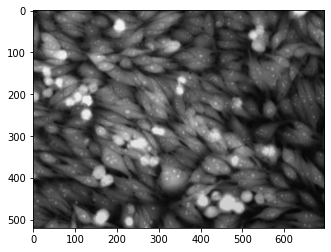

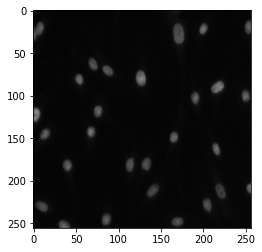

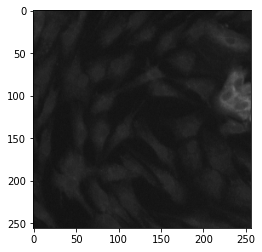

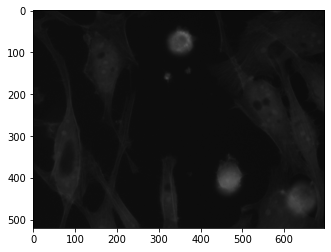

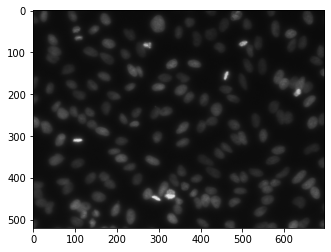

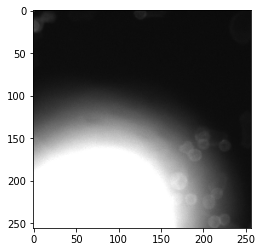

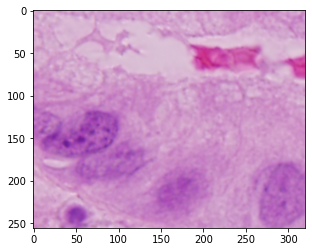

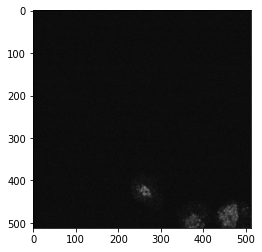

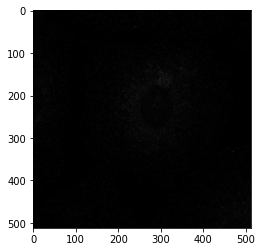

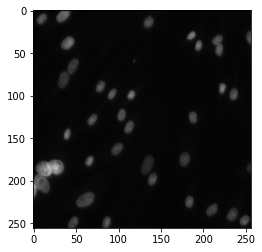

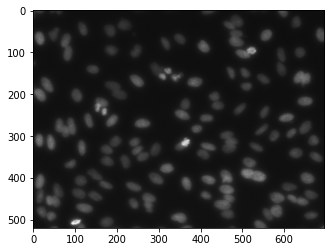

In [ ]:
filename = 'stage2_solution_final.csv'
decode_submission(filename, visualize=False)

#sanity_check(max_n_images=15)

In [ ]:
import shutil

df = pd.read_csv(filename, sep=',')

df_ignore = df[df['Usage'] == "Ignored"]

folders = 0
for i, test_id in enumerate(test_id_list):

    if((df_ignore['ImageId'] == test_id).any()):
        dir = stage1_test_dir + '/' + test_id
        shutil.rmtree(dir)
        folders += 1

print('Folders removed: ', folders)
    

Folders removed:  2913


In [ ]:
len(os.listdir(stage1_test_dir))

106

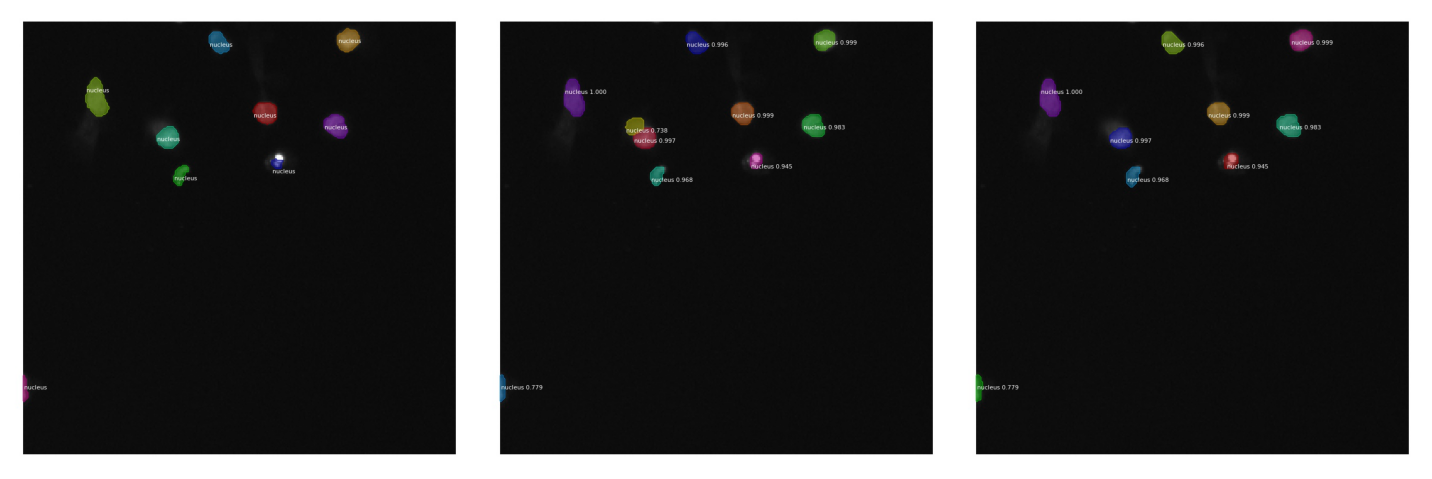

In [ ]:
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(20, 20))
plt.rcParams["figure.autolayout"] = True
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# reading images
Image1 = cv2.imread('TF2 Project/Preds test 1/0_gt.jpg')
Image2 = cv2.imread('TF2 Project/Preds test 1/0_pred.jpg')
Image3 = cv2.imread('TF2 Project/Preds test 1/0_pred_post.jpg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')

  
plt.savefig('TF2 Project/test' + '.jpg', bbox_inches='tight', pad_inches=0)